## This notebook uses regression.ipynb as a base and predicts with XGBoost algorithm only the IA supernovae cases and filter the objects with few interpolation points (on GP preprocess step) in order to obtain a better RMSE score.
The objective of this notebook was to understand the possible errors on regression methods and improve them.

In [2]:
%load_ext autoreload
%autoreload 2
import os 
import sys
import pandas as pd
import numpy as np
import xgboost as xgb

In [3]:
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.modeling.functions_regression import linear_regression, normal_linear_regression, evaluate

In [4]:
pd.set_option("display.max_rows", 8)

In [5]:
df = pd.read_pickle("../../data/df.pkl")
df

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f14,f15,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC
ID,,,,,,,,,,,,,,,,,,,,,
SN10001,"[[0.0, 2.326, 4.792], [2.0, 4.617, 2.249], [9....","[[0.031000000002677552, 8.672, 5.439], [2.1560...","[[0.01600000000325963, 8.834, 5.339], [2.13999...","[[0.06199999999807915, 6.026, 4.693], [2.18699...","[0.0, 1.1313535353535435, 2.262707070707087, 3...","([0.0, 0.818888888888886, 1.637777777777772, 2...","([0.031000000002677552, 1.141676767679467, 2.2...","([0.01600000000325963, 1.076565656568908, 2.13...","([0.06199999999807915, 1.1927272727253795, 2.3...","[9.251771363349247, 8.972870155014132, 8.79160...",...,6.048710,-11.165995,23.954122,18.206973,6.125696,9.448978,-0.078004,II,False,0.59162
SN100023,"[[6.984000000004016, 5.679, 6.387], [7.9920000...","[[7.00800000000163, 4.698, 7.145], [8.02300000...","[[0.0, 16.04, 17.59], [6.992000000005646, 19.8...","[[4.121000000006461, 18.01, 3.601], [7.0230000...","[0.0, 1.3437474747475018, 2.6874949494950036, ...","([6.984000000004016, 8.256929292933277, 9.5298...","([7.00800000000163, 8.189737373738987, 9.37147...","([0.0, 0.8994242424242942, 1.7988484848485884,...","([4.121000000006461, 5.423121212127635, 6.7252...","[12.22728787505526, 11.357060718395505, 10.716...",...,33.710197,-11.581964,28.655932,19.743614,4.619543,37.266792,-16.596040,II,False,0.79264
SN10005,"[[10.027000000001863, 4.996, 8.081], [33.94500...","[[0.015000000006693881, 0.2977, 2.206], [18.94...","[[0.0, 1.033, 1.325], [13.015000000006694, 0.4...","[[0.03500000000349246, 1.826, 3.029], [48.875,...","[0.0, 1.0381919191919462, 2.0763838383838924, ...","([10.027000000001863, 10.782565656567513, 11.5...","([0.015000000006693881, 1.0530404040470573, 2....","([0.0, 1.0281717171717606, 2.056343434343521, ...","([0.03500000000349246, 1.0222929292964054, 2.0...","[2.000004411755352, 2.000003547336676, 2.00000...",...,-26.554909,15.768490,16.436792,17.114795,-20.292951,-24.222566,-11.295562,Ia,True,1.08327
SN10007,"[[0.0, 6.266, 10.48], [10.105999999999767, 17....","[[0.03200000000651926, 7.161, 9.313], [2.01600...","[[2.0, 1.24, 2.429], [10.121000000006461, 20.0...","[[0.9770000000062282, 0.6586, 5.329], [15.9930...","[0.0, 1.5136565656566285, 3.027313131313257, 4...","([0.0, 1.5132626262626456, 3.0265252525252913,...","([0.03200000000651926, 1.5451717171782005, 3.0...","([2.0, 3.49314141414145, 4.9862828282829, 6.47...","([0.9770000000062282, 2.480787878794107, 3.984...","[11.341091517194192, 8.812204685737349, 6.9798...",...,-99.877031,21.670852,24.155364,-26.622112,-27.616185,-19.981432,49.299250,Ia,True,0.82331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN99899,"[[15.004000000000815, 1.352, 3.403], [53.87900...","[[0.0, 4.81, 2.212], [29.9059999999954, 0.0751...","[[7.019999999996799, 2.434, 1.445], [15.027999...","[[0.023999999997613486, 3.478, 3.05], [9.03499...","[0.0, 0.8468686868686516, 1.6937373737373032, ...","([15.004000000000815, 15.689212121212893, 16.3...","([0.0, 0.8468686868686516, 1.6937373737373032,...","([7.019999999996799, 7.785939393936206, 8.5518...","([0.023999999997613486, 0.8200808080784021, 1....","[20.712009726735538, 19.059663100848315, 17.84...",...,-20.467690,98.233177,-82.338152,40.618768,53.697825,-2.771304,-35.327613,II,False,0.65243
SN99921,"[[0.0, 8.327, 4.797], [2.0, 9.834, 2.261], [9....","[[0.031000000002677552, 22.78, 5.454], [2.1560...","[[0.01600000000325963, 26.73, 5.361], [2.13999...","[[0.06199999999807915, 15.19, 4.7], [2.1869999...","[0.0, 1.2923333333333222, 2.5846666666666445, ...","([0.0, 1.1299292929293416, 2.2598585858586833,...","([0.031000000002677552, 1.3230202020228414, 2....","([0.01600000000325963, 1.3080606060638358, 2.6...","([0.06199999999807915, 1.2726666666647435, 2.4...","[14.025137598441496, 16.23859348218353, 17.966...",...,30.582545,-38.454611,33.695746,32.105615,-3.304444,32.695392,-16.237457,II,False,0.69650
SN99946,"[[11.961000000002969, 1.5

### IA Filter

In [43]:
df = df.loc[df.type_bool == True]
df

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f14,f15,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC
ID,,,,,,,,,,,,,,,,,,,,,
SN10005,"[[10.027000000001863, 4.996, 8.081], [33.94500...","[[0.015000000006693881, 0.2977, 2.206], [18.94...","[[0.0, 1.033, 1.325], [13.015000000006694, 0.4...","[[0.03500000000349246, 1.826, 3.029], [48.875,...","[0.0, 1.0381919191919462, 2.0763838383838924, ...","([10.027000000001863, 10.782565656567513, 11.5...","([0.015000000006693881, 1.0530404040470573, 2....","([0.0, 1.0281717171717606, 2.056343434343521, ...","([0.03500000000349246, 1.0222929292964054, 2.0...","[2.000004411755352, 2.000003547336676, 2.00000...",...,-26.554909,15.768490,16.436792,17.114795,-20.292951,-24.222566,-11.295562,Ia,True,1.08327
SN10007,"[[0.0, 6.266, 10.48], [10.105999999999767, 17....","[[0.03200000000651926, 7.161, 9.313], [2.01600...","[[2.0, 1.24, 2.429], [10.121000000006461, 20.0...","[[0.9770000000062282, 0.6586, 5.329], [15.9930...","[0.0, 1.5136565656566285, 3.027313131313257, 4...","([0.0, 1.5132626262626456, 3.0265252525252913,...","([0.03200000000651926, 1.5451717171782005, 3.0...","([2.0, 3.49314141414145, 4.9862828282829, 6.47...","([0.9770000000062282, 2.480787878794107, 3.984...","[11.341091517194192, 8.812204685737349, 6.9798...",...,-99.877031,21.670852,24.155364,-26.622112,-27.616185,-19.981432,49.299250,Ia,True,0.82331
SN100361,"[[6.957000000002154, 16.02, 23.92], [7.9690000...","[[0.023000000001047738, 4.903, 3.324], [6.9840...","[[0.0, 0.7103, 2.626], [5.9760000000023865, 5....","[[8.055000000000291, 2.567, 2.665], [15.035000...","[0.0, 1.3031111111111275, 2.606222222222255, 3...","([6.957000000002154, 8.15910101010318, 9.36120...","([0.023000000001047738, 1.315494949496019, 2.6...","([0.0, 1.3026767676768058, 2.6053535353536117,...","([8.055000000000291, 9.27674747474778, 10.4984...","[8.233549869515556, 9.464488874691614, 10.4511...",...,102.074783,-95.727930,4.861555,-29.749073,23.442440,5.441237,12.503390,Ia,True,0.90012
SN100471,"[[0.0, 3.79, 4.764], [11.969000000004598, 1.67...","[[0.023999999997613486, 2.202, 3.146], [3.0429...","[[0.008000000001629815, 0.4567, 2.129], [3.004...","[[0.046999999998661224, 6.92, 2.486], [3.07500...","[0.0, 1.4638181818181601, 2.9276363636363203, ...","([0.0, 1.3621414141414037, 2.7242828282828073,...","([0.023999999997613486, 1.4875757575733735, 2....","([0.008000000001629815, 1.3701818181834458, 2....","([0.046999999998661224, 1.3283737373723963, 2....","[5.63245418874034, 5.603687474301877, 5.594769...",...,-40.831628,28.629443,12.801879,-0.555542,13.065768,-21.776767,9.358561,Ia,True,0.92640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN99404,"[[0.0, 6.586, 10.48], [15.980999999999767, 166...","[[22.0, 3.161, 11.98], [40.97700000000623, 15....","[[0.01600000000325963, 8.663, 7.843], [2.0, 1....","[[15.993000000002212, 5.828, 6.542], [29.95700...","[0.0, 1.745343434343478, 3.490686868686956, 5....","([0.0, 1.7352424242424678, 3.4704848484849355,...","([22.0, 23.382101010101024, 24.76420202020205,...","([0.01600000000325963, 1.7511212121244906, 3.4...","([15.993000000002212, 17.57679797980021, 19.16...","[475.9257034984372, 265.54157358525424, 120.22...",...,496.744492,-1269.560018,826.117566,-2224.164801,66.007045,341.497556,-173.911137,Ia,True,0.89529
SN99438,"[[0.0, 2.33, 2.55], [7.894000000000233, 3.805,...","[[0.030999999995401595, 0.006543, 3.683], [7.9...","[[0.014999999999417923, 0.4446, 1.3], [14.0039...","[[0.06199999999807915, 1.497, 4.486], [7.97199...","[0.0, 1.7255757575757058, 3.4511515151514116, ...","([0.0, 1.6948383838383538, 3.3896767676767077,...","([0.030999999995401595, 1.75597979797521, 3.48...","([0.014999999999417923, 1.7298888888882826, 3....","([0.06199999999807915, 1.7869494949475417, 3.5...","[6.789900493579756, 7.110462975693107, 7.57937...",...,-3.768615,-34.417710,32.878026,-33.942007,34.613437,61.324861,-51.210871,Ia,True,0.75966
SN99457,"[[0.0, 10.06, 4.

### Interpolation Points filter

In [44]:
dfs = {}
for cut in [2,3,4,5,6,7,8,9,10]:
    mask = (df.desg.str.len() > cut) & (df.desi.str.len() > cut) & (df.desr.str.len() > cut) & (df.desz.str.len() > cut) 
    dfs['df_cut'+str(cut)] = df.loc[mask]

In [45]:
for key in dfs.keys():
    regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
    X = dfs[key].loc[:,'f1':'f20']
    y = np.array(dfs[key].REDSHIFT_SPEC)
    ans_real_19 = linear_regression(X, y, int(len(dfs[key])/1100), 5, regressor)
    ans_real_2 = linear_regression(X, y, 2, 5, regressor)
    ans_normal = normal_linear_regression(X, y, 5, regressor)
    print(f'\n \n \n Values for {key}' + f'. DF len = {len(X)}' + '\n')
    evaluate(ans_real_19, ans_real_2, ans_normal)


 
 
 Values for df_cut2. DF len = 5047

 RMSE Means : 
 
 Validate 19:  0.17523837546419674 
 Validate 2:  0.16867416902872573 
 No Validation:  0.16332330875137668

 MAE Means : 
 
 Validate 19:  0.1423576067427603 
 Validate 2:  0.13631383152670593 
 No Validation:  0.13185943404405026

 
 
 Values for df_cut3. DF len = 4930

 RMSE Means : 
 
 Validate 19:  0.17509201572448074 
 Validate 2:  0.16831202922283878 
 No Validation:  0.16302307070303132

 MAE Means : 
 
 Validate 19:  0.14226952695788414 
 Validate 2:  0.13616588173135522 
 No Validation:  0.13154750892776698

 
 
 Values for df_cut4. DF len = 4751

 RMSE Means : 
 
 Validate 19:  0.17536111574555627 
 Validate 2:  0.16808839939241713 
 No Validation:  0.16277862248306113

 MAE Means : 
 
 Validate 19:  0.14238601594002628 
 Validate 2:  0.13594744753062155 
 No Validation:  0.13149904193453787

 
 
 Values for df_cut5. DF len = 4551

 RMSE Means : 
 
 Validate 19:  0.17578101059837992 
 Validate 2:  0.16838883910649313 

#### Fake Optimal value: Cut = 6
##### RMSE value Before cut: 0.175454
##### RMSE value with cut  6: 0.17286
    Note: Validate 19 on "Only IA Filter" isnt 19, it's more or less 5.Considering it, we should consider validate 2 (and maybe test on other samples which were cut off)
    
#### Real (validate 2) Optimal value: Cut = 4
##### RMSE value Before cut: 0.16885
##### RMSE value with cut  4: 0.16808

    Note2: For only 8^10-4 RMSE improvement, it isnt worth cut values.

## Regression filtering only values within mean +- std

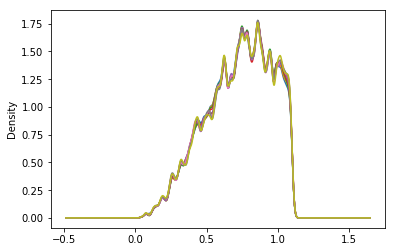

In [46]:
for key in dfs.keys():
    dfs[key].REDSHIFT_SPEC.plot.kde(bw_method=0.05)

### ANS: Results are similar, no significant group discarded.
##### No need to filter by quantiles or analyse boxplot.